# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 8 апреля 2019, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 8 апреля, -4 балла после 06:00 15 апреля, -6 баллов после 06:00 22 апреля  -8 баллов после 06:00 29 апреля.

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext pycodestyle_magic

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

Здравствуйте, уважаемые студенты! 

В этом задании мы будем реализовать линейные модели. Необходимо реализовать линейную и логистическую регрессии с L2 регуляризацией

# Теоретическое введение



*** Что почитать по теории ***

Одна из лучших книг по ML $-$ "Pattern Recognition and Machine Learning" Bishop, Christopher. 

Линейная регрессия решает задачу регрессии и оптимизирует функцию потерь MSE 

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right], $$ где $y_i$ $-$ целевая функция,  $a_i = a(x_i) =  \langle\,x_i,w\rangle ,$ $-$ предсказание алгоритма на объекте $x_i$, $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).


Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
$w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.



Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал для линейной регрессии тогда принимает вид:

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right] + \frac{1}{C}R(w) $$

Для логистической: 
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК академиком Тихоновым https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно. 

Вам нужно добавить соотвествущую Вашему варианту $L2$ регуляризацию.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации.



Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку, выбрать размер мини-батча (от 1 до размера выборки)
        2) Почитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в мини-батче)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается. 
* Правило останова - максимальное количество эпох
    


# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Градиент для линейной регрессии.
* Выпишите формулу обновления весов для линейной регрессии с L2 регуляризацией для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент?

***Ваше решение здесь***
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

$$Q_r(w) =  Q(w) + \frac{1}{C}R(w) $$

$$Q_r(w) =  \frac{1}{N}\left[\sum_i L(w) \right] + \frac{1}{C}R(w) $$

Для мини-батч градиентного спуска размера n считаем градиент:
$$\nabla_w Q_r^*(w_{old}) = \frac{1}{n}\nabla_w\left[\sum_{j=1}^{n} L(w_{old}, x_j, y_j) \right] + \frac{1}{C}\nabla_w R(w_{old}) $$

$$ w_{new} = w_{old} - \alpha \nabla_w Q_r^*(w_{old}) $$

$$\nabla_w Q_r^*(w_{old}) = \frac{1}{n}\left[\sum_{j=1}^{n} \nabla_w L(w_{old}, x_j, y_j) \right] + \frac{2}{C}w_{old} $$


$$ w_{new} = w_{old} - \frac{\alpha}{n}\left[\sum_{j=1}^{n} \nabla_w L(w_{old}, x_j, y_j) \right] - \frac{2\alpha}{C}w_{old} $$

$$ w_{new} = w_{old}( 1 - \frac{2\alpha}{C} ) - \frac{\alpha}{n}\left[\sum_{j=1}^{n} \nabla_w L(w_{old}, x_j, y_j) \right] $$

если функция потерь задана $L(w) = ( y_i - a_i ) ^ 2 $,
где $y_i$ $-$ целевая функция,  $a_i = a(x_i) =  \langle\,x_i,w\rangle ,$ $-$ предсказание алгоритма на объекте $x_i$,
соответственно, функционал потерь $Q(w) =  \frac{1}{N}\left[\sum_i ( y_i - a_i ) ^ 2 \right]$, то градиент:

$$\nabla_w Q_r^*(w_{old}) = \frac{2}{n}\left[\sum_{j=1}^{n}(\langle\,x_j,w_{old}\rangle - y_j ) x_j \right] + \frac{2}{C}w_{old} $$



веса обновляются:

$$ w_{new} = w_{old} - \alpha( \frac{2}{n}\left[\sum_{j=1}^{n}( \langle\,x_j,w_{old}\rangle - y_j ) x_j \right] +
\frac{2}{C} w_{old} ) $$

$$ w_{new} = w_{old}( 1 - \frac{2\alpha}{C} ) - \frac{2\alpha}{n}\left[\sum_{j=1}^{n}( \langle\,x_j,w_{old}\rangle - y_j ) x_j \right] $$




Задача 2. Градиент для логистической регрессии.
* Выпишите формулу обновления весов для логистической регрессии с L2 регуляризацией  для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент? Как соотносится этот градиент с градиентом, возникающий в задаче линейной регрессии?

***Ваше решение здесь***

$$ w_{new} = w_{old} - \alpha \nabla_w Q_r^*(w_{old}) $$

Для мини-батч градиентного спуска размера n считаем градиент:
$$\nabla_w Q_r^*(w_{old}) = \frac{1}{n}\nabla_w\left[\sum_{j=1}^{n} L(w_{old}, x_j, y_j) \right] + \frac{1}{C}\nabla_w R(w_{old}) $$

$$L(w) =  -( y_i \log a_i + ( 1 - y_i ) \log ( 1 - a_i ) ) $$,
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$, $a(x_i) =  \sigma( \langle\,x_i,w\rangle ) = \frac{1}{1 + \exp (-\langle\,x_i,w\rangle)}$

$$\nabla_w L(w) = -( y_i \frac{1}{a_i} - ( 1 - y_i ) \frac{1}{1 - a_i})\nabla_w a_i = -( y_i ( 1 - a_i ) - a_i ( 1 - y_i ) )\frac{1}{a_i ( 1 - a_i )} ( -a_i ) ( 1 - a_i ) ( -x_i) = ( a_i - y_i ) x_i $$


$$\nabla_w Q_r^*(w_{old}) = \frac{1}{n}\left[\sum_{j=1}^{n}( \sigma( \langle\,x_i,w\rangle ) - y_j ) x_j \right] + \frac{2}{C}w_{old} $$



веса обновляются:

$$ w_{new} = w_{old} - \alpha(\frac{1}{n}\left[\sum_{j=1}^{n}( \sigma( \langle\,x_i,w\rangle ) - y_j ) x_j \right] + \frac{2}{C}w_{old}) $$

$$ w_{new} = w_{old}(1 - \frac{2\alpha}{C}) - \frac{\alpha}{n}\left[\sum_{j=1}^{n}(\sigma( \langle\,x_i,w\rangle ) - y_j ) x_j \right] $$


Задача 3. Точное решение линейной регрессии

На лекции было показано, что точное решение линейной регрессии имеет вид $w = (X^TX)^{-1}X^TY $. 
* Покажите, что это действительно является точкой минимума в случае, если матрица X имеет строк не меньше, чем столбцов и имеет полный ранг. Подсказка: посчитайте Гессиан и покажите, что в этом случае он положительно определен. 
* Выпишите точное решение для модели с $L2$ регуляризацией

***Ваше решение здесь***

Задача 4.  Предсказываем вероятности.

Когда говорят о логистической регрессии, произносят фразу, что она "предсказывает вероятности положительного класса". Давайте разберемся, что же за этим стоит. Посчитаем математическое ожидание функции потерь и проверим, что предсказание алгоритма, оптимизирующее это мат. ожидание, будет являться вероятностью положительного класса. 

И так, функция потерь на объекте $x_i$, который имеет метку $y_i \in \{0,1\}$  для предсказания $a(x_i)$ равна:
$$L(y_i, b) =-[y_i == 1] \log a(x_i)  - [y_i == 0] \log(1 - a(x_i)) $$

Где $[]$ означает индикатор $-$ он равен единице, если значение внутри него истинно, иначе он равен нулю. Тогда мат. ожидание при условии конкретного $x_i$  по определение мат. ожидания дискретной случайной величины:
$$E(L | x_i) = -p(y_i = 1 |x_i ) \log a(x_i)  - p(y_i = 0 | x_i) \log( 1 - a(x_i))$$
* Докажите, что значение $a(x_i)$, минимизирующее данное мат. ожидание, в точности равно $p(y_i = 1 |x_i)$, то есть равно вероятности положительного класса.

Подсказка: возможно, придется воспользоваться, что  $p(y_i = 1 | x_i) + p(y_i = 0 | x_i) = 1$

#  Реализация линейной модели (5 баллов)

## Зачем нужны батчи?


Как Вы могли заметить из теоретического введения, что в случае SGD, что в случа mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам *** не нужна вся выборка***. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчом).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными numpy array. 





## Немножко про генераторы в Python



Идея считывания данных кусками удачно ложится на так называемые ***генераторы*** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, ***штрафоваться это никак не будет***. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены. 

Подробнее можно почитать вот тут https://anandology.com/python-practice-book/iterators.html


К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова ***yield***. Ниже Вы можете насладиться  генератором чисел Фибоначчи.

In [2]:
def fib(max_iter=4):
    a, b = 0, 1
    iter_num = 0
    while 1:
        yield a
        a, b = b, a + b
        iter_num += 1
        if iter_num == max_iter:
            break

Вот так можно сгенерировать последовательность Фибоначчи. 

Заметьте, что к генераторам можно применять некоторые стандартные функции из Python, например enumerate.

In [3]:
new_generator = fib()
for j, fib_val in enumerate(new_generator):
    print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Пересоздавая объект, можно сколько угодно раз генерировать заново последовательность. 

In [4]:
for i in range(0, 3):
    new_generator = fib()
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


А вот так уже нельзя.

In [5]:
new_generator = fib()
for i in range(0, 3):
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [6]:
def batch_generator(X, y, shuffle=True, batch_size=1):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """
        
    n_ind = y.shape[0]
    if shuffle:
        ind_ = np.random.permutation(np.arange(n_ind))
    else:
        ind_ = np.array(n_ind)
        
    for i in range(n_ind // batch_size):
        ind_batch = ind_[batch_size * i: batch_size * (i + 1)]
        X_batch = X[ind_batch]
        y_batch = y[ind_batch]
        yield (X_batch, y_batch)

In [11]:
# %%pycodestyle
from sklearn.base import BaseEstimator, ClassifierMixin


def sigmoid(x):
    """
    Вычисляем значение сигмоида.
    X - выход линейной модели
    """

    sigm_value_x = 1. / (1. + np.exp(-x))
    return sigm_value_x


class MySGDClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, batch_generator, batch_size, C=1,
                 alpha=0.01, max_epoch=10, model_type='lin_reg'):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        model_type - тим модели, lin_reg или log_reg
        """

        if C == 0:
            self.C = 0
        else:
            self.C = 1 / C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.batch_size = batch_size
        self.errors_log = {'iter': [],
                           'loss': np.array([]),
                           'loss_per_epoch': []}
        self.model_type = model_type

    def calc_dot(self, X_batch):
        """
        Считаем  скалярное произведение
        X_batch - матрица объекты-признаки по батчу
        """

        if X_batch.shape[1] != self.weights.shape[0]:
            y_dot = np.dot(np.c_[X_batch, np.ones(X_batch.shape[0])],
                           self.weights.T)
        else:
            y_dot = np.dot(X_batch, self.weights.T)
        if self.model_type == 'log_reg':
            y_dot = sigmoid(y_dot)
        return y_dot

    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """

        y_hat = self.calc_dot(X_batch)
        if self.model_type == 'lin_reg':
            loss = np.mean(np.square(y_batch - y_hat))
        elif self.model_type == 'log_reg':
            epsilon = 0.0001
            y_one = y_batch * np.log(y_hat + epsilon)
            y_zero = (1. - y_batch) * np.log(1. - y_hat + epsilon)
            loss = - np.mean(y_one + y_zero)
        L2 = self.C * np.dot(self.weights, self.weights.T)
        loss += L2
        return loss

    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем  градиент функции потерь по батчу
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """

        y_hat = self.calc_dot(X_batch)
        err = np.expand_dims((y_hat - y_batch), axis=1)
        loss_grad = np.mean(err * X_batch, axis=0)
        if self.model_type == 'lin_reg':
            loss_grad *= 2
        L2_grad = 2 * self.C * self.weights
        loss_grad += L2_grad
        return loss_grad

    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """

        self.weights -= self.alpha * new_grad

    def fit(self, X, y):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''

        self.classes = np.unique(y)
        self.weights = np.random.rand(X.shape[1] + 1)
        self.steps_per_epoch = math.ceil(X.shape[0] / self.batch_size)
        for n in range(0, self.max_epoch):
            new_epoch_generator =\
                self.batch_generator(np.c_[X, np.ones(X.shape[0])], y,
                                     shuffle=True, batch_size=self.batch_size)
            batch_loss_aver = 0
            for batch_num, new_batch in enumerate(new_epoch_generator):
                X_batch = new_batch[0]
                y_batch = new_batch[1]
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                self.update_weights(batch_grad)
                batch_loss = self.calc_loss(X_batch, y_batch)
                batch_loss_aver += batch_loss
                self.errors_log['loss'] = np.append(self.errors_log['loss'],
                                                    batch_loss)
            self.errors_log['iter'].append(n)
            self.errors_log['loss_per_epoch'].append(batch_loss_aver /
                                                     self.steps_per_epoch)
        return self

    def predict(self, X, t=0.5):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        Не забудте тип модели (линейная или логистическая регрессия)!
        '''
        y_hat = self.calc_dot(X)
        if self.model_type == 'log_reg':
            ind = (y_hat > t).astype(np.int)
            y_hat = self.classes[ind]
        return y_hat.ravel()

    def score(self, X, y):
        if self.model_type == 'lin_reg':
            u = self.calc_loss(X, y)
            v = np.mean(np.square(y - y.mean()))
            return (1. - u / v)
        else:
            y_proba = self.predict(X)
            return np.mean(y_proba == y)

Запустите обе регрессии на синтетических данных. 


Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

In [13]:
def plot_decision_boundary(clf, w):
    x = np.linspace(-5, 8)
    print("weights: {}".format(w))
# w[0] * x_0 + w[1]* x_1 + w[-1] = 1/2
    yy = (0.5 - w[0] * x - w[-1]) / w[1]
    plt.plot(x, yy)

weights: [ 0.14122419 -0.16046338 -0.09110931]
my_lin score:  0.5619628836660737
sklearn lin score:  0.5657182322943402
weights: [ 0.80834835 -0.79639456 -3.37874474]
my_log score:  0.9025
sklearn log score:  0.885


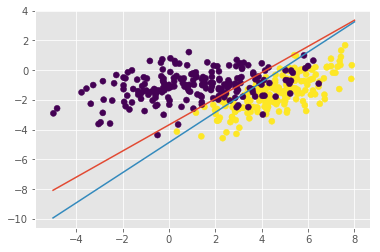

In [32]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

batch_size = 2

my_lin_reg = MySGDClassifier(batch_generator,
                             batch_size=batch_size,
                             C=100,
                             alpha=0.001,
                             max_epoch=30,
                             model_type='lin_reg')
my_lin_reg.fit(X, y)
plot_decision_boundary(my_lin_reg, my_lin_reg.weights)
print('my_lin score: ', my_lin_reg.score(X, y))

from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
print('sklearn lin score: ', lin_reg.score(X, y))

my_log_reg = MySGDClassifier(batch_generator,
                             batch_size=batch_size,
                             C=0,
                             alpha=0.01,
                             max_epoch=30,
                             model_type='log_reg')
my_log_reg.fit(X, y)
plot_decision_boundary(my_log_reg, my_log_reg.weights)
print('my_log score: ', my_log_reg.score(X, y))

from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver='lbfgs')
log_reg.fit(X, y)
print('sklearn log score: ', log_reg.score(X, y))

plt.scatter(X[:,0], X[:,1], c=y)

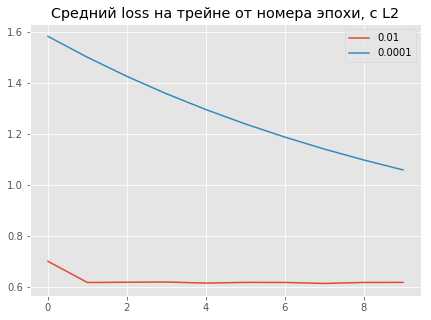

In [33]:
plt.figure(figsize=(7, 5))
my_log_reg = MySGDClassifier(batch_generator, batch_size, C=1, alpha=0.01, max_epoch=10, model_type='log_reg')
my_log_reg.fit(X, y)
plt.plot(range(0, 10), my_log_reg.errors_log['loss_per_epoch'])

my_log_reg = MySGDClassifier(batch_generator, batch_size, C=1, alpha=0.0001, max_epoch=10, model_type='log_reg')
my_log_reg.fit(X, y)
plt.plot(range(0, 10), my_log_reg.errors_log['loss_per_epoch'])

plt.legend(('0.01', '0.0001'))
plt.title('Средний loss на трейне от номера эпохи, c L2')

plt.show()

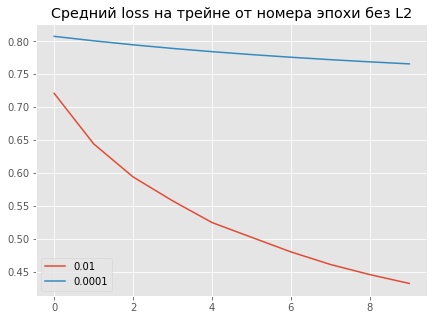

In [34]:
plt.figure(figsize=(7, 5))

my_log_reg = MySGDClassifier(batch_generator, batch_size, C=0, alpha=0.01, max_epoch=10, model_type='log_reg')
my_log_reg.fit(X, y)
plt.plot(range(0, 10), my_log_reg.errors_log['loss_per_epoch'])

my_log_reg = MySGDClassifier(batch_generator, batch_size, C=0, alpha=0.0001, max_epoch=10, model_type='log_reg')
my_log_reg.fit(X, y)
plt.plot(range(0, 10), my_log_reg.errors_log['loss_per_epoch'])

plt.legend(('0.01', '0.0001'))
plt.title('Средний loss на трейне от номера эпохи без L2')

plt.show()

Далее будем анализировать Ваш алгоритм. 
Для этих заданий используйте датасет ниже.

In [35]:
from sklearn.datasets import make_classification

In [36]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимости обеих регрессией на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике. 

$N$ можно брать 10, 50, 100 и т.д. 

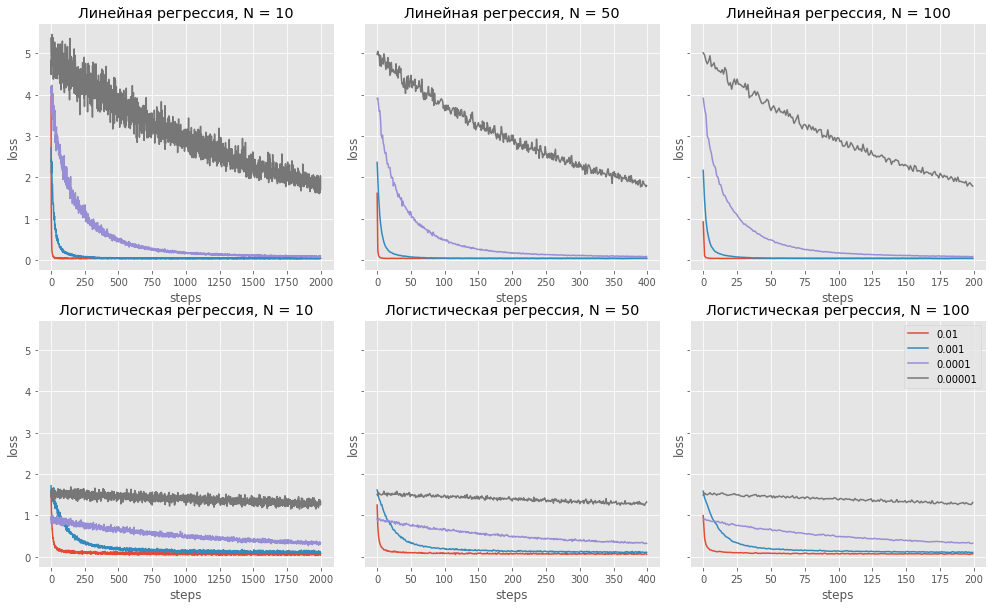

In [37]:
fig, axes = plt.subplots(2, 3, sharex=False, sharey=True)
fig.set_figheight(10)
fig.set_figwidth(17)

batch_size = 50
N = [10, 50, 100]
alpha = [0.01, 0.001, 0.0001, 0.00001]

for a in alpha:
    my_lin_reg = MySGDClassifier(batch_generator,
                                 batch_size=batch_size,
                                 C=0,
                                 alpha=a,
                                 max_epoch=10,
                                 model_type='lin_reg')
    my_lin_reg.fit(X, y)
    my_log_reg = MySGDClassifier(batch_generator,
                                 batch_size=batch_size,
                                 C=0,
                                 alpha=a,
                                 max_epoch=10,
                                 model_type='log_reg')
    my_log_reg.fit(X, y)

    for i, n in enumerate(N):
        size = 1000000 // (batch_size * n)
        n_steps = range(0, size)
        aver_loss_lin = np.mean(np.array(my_lin_reg.errors_log['loss']).reshape(-1, n), axis=1).ravel()
        axes[0, i].set_title('Линейная регрессия, N = {0}'.format(n))
        axes[0, i].set_xlabel('steps')
        axes[0, i].set_ylabel('loss')
        axes[0, i].plot(n_steps, aver_loss_lin)

        aver_loss_log = np.mean(np.array(my_log_reg.errors_log['loss']).reshape(-1, n), axis=1).ravel()
        axes[1, i].set_title('Логистическая регрессия, N = {0}'.format(n))
        axes[1, i].set_xlabel('steps')
        axes[1, i].set_ylabel('loss')
        axes[1, i].plot(n_steps, aver_loss_log)

plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.legend(('0.01', '0.001', '0.0001', '0.00001'))
plt.show()

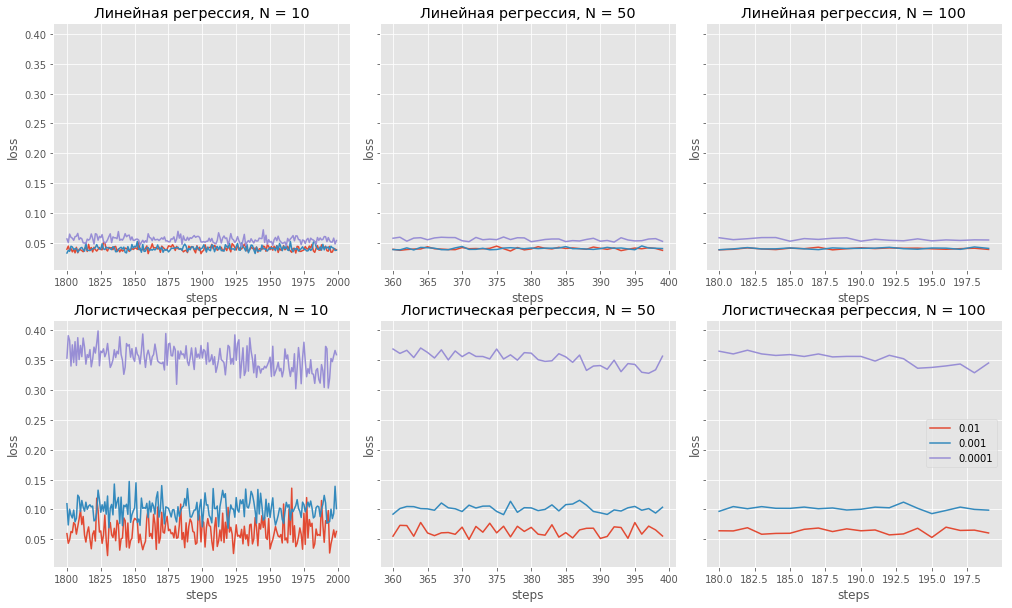

In [38]:
fig, axes = plt.subplots(2, 3, sharex=False, sharey=True)
fig.set_figheight(10)
fig.set_figwidth(17)

batch_size = 50
N = [10, 50, 100]
alpha = [0.01, 0.001, 0.0001]
lin_optimal = np.zeros(len(alpha))
log_optimal = np.zeros(len(alpha))

for _, a in enumerate(alpha):
    my_lin_reg = MySGDClassifier(batch_generator,
                                 batch_size=batch_size,
                                 C=0,
                                 alpha=a,
                                 max_epoch=10,
                                 model_type='lin_reg')
    my_lin_reg.fit(X, y)
    my_log_reg = MySGDClassifier(batch_generator,
                                 batch_size=batch_size,
                                 C=0,
                                 alpha=a,
                                 max_epoch=10,
                                 model_type='log_reg')
    my_log_reg.fit(X, y)

    for i, n in enumerate(N):
        size = 1000000 // (batch_size * n)
        n_steps = range(0, size)
        aver_loss_lin = np.mean(np.array(my_lin_reg.errors_log['loss']).reshape(-1, n), axis=1).ravel()
        axes[0, i].set_title('Линейная регрессия, N = {0}'.format(n))
        axes[0, i].set_xlabel('steps')
        axes[0, i].set_ylabel('loss')
        axes[0, i].plot(n_steps[9 * size // 10: ], aver_loss_lin[9 * size // 10: ])

        aver_loss_log = np.mean(np.array(my_log_reg.errors_log['loss']).reshape(-1, n), axis=1).ravel()
        axes[1, i].set_title('Логистическая регрессия, N = {0}'.format(n))
        axes[1, i].set_xlabel('steps')
        axes[1, i].set_ylabel('loss')
        axes[1, i].plot(n_steps[9 * size // 10: ], aver_loss_log[9 * size // 10: ])

    lin_optimal[_] = np.array(my_lin_reg.errors_log['loss']).min()
    log_optimal[_] = np.array(my_log_reg.errors_log['loss']).min()

plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.legend(('0.01', '0.001', '0.0001'))
plt.show()

Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?

In [39]:
# При уменьшающемся значении alpha скорость сходимости алгоритма падает, необходимо увеличивать число шагов до останова.

In [40]:
alpha_lin = alpha[lin_optimal.argmin()]
print("Наилучшее значение alpha для лин.регрессии: {0}\nНаименьший loss лин.регрессии: {1}"
      .format(alpha_lin, lin_optimal.min()))

alpha_log = alpha[log_optimal.argmin()]
print("Наилучшее значение alpha для лог.регрессии: {0}\nНаименьший loss лог.регрессии: {1}"
      .format(alpha_log, log_optimal.min()))

Наилучшее значение alpha для лин.регрессии: 0.001
Наименьший loss лин.регрессии: 0.013028868367319526
Наилучшее значение alpha для лог.регрессии: 0.01
Наименьший loss лог.регрессии: 0.005691716544814448


Изобразите график среднего значения весов для обеих регрессий в зависимости от коеф. регуляризации С из `np.logspace(3, -3, 10)` 

aver_weights_lin:  [1.21479278e-01 1.07390643e-01 1.04568636e-01 9.04992014e-02
 5.31440534e-02 1.76080307e-02 4.61239942e-03 9.91851179e-04
 2.15772422e-04 4.23654707e-05]
aver_weights_log:  [ 2.02739907e-01  3.16480786e-01  4.55138202e-01  2.97161844e-01
  1.69452225e-01 -2.72535173e-03 -2.14933153e-03 -4.68752647e-04
 -1.08212158e-04 -2.14507712e-05]


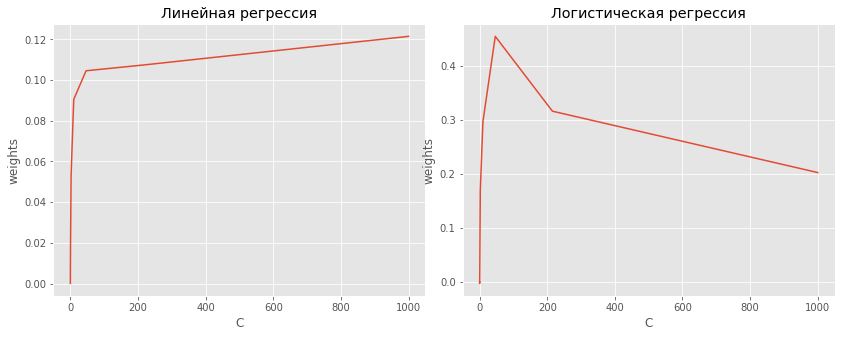

In [41]:
fig, axes = plt.subplots(1, 2, sharex=False, sharey=False)
fig.set_figheight(5)
fig.set_figwidth(14)

batch_size = 100
C = np.logspace(3, -3, 10)
aver_weights_lin = np.zeros(len(C))
aver_weights_log = np.zeros(len(C))

for i, c in enumerate(C):
    my_lin_reg = MySGDClassifier(batch_generator,
                                 batch_size=batch_size,
                                 C=c,
                                 alpha=0.0001,
                                 max_epoch=10,
                                 model_type='lin_reg')
    my_lin_reg.fit(X, y)
    my_log_reg = MySGDClassifier(batch_generator,
                                 batch_size=batch_size,
                                 C=c,
                                 alpha=0.0001,
                                 max_epoch=10,
                                 model_type='log_reg')
    my_log_reg.fit(X, y)
    aver_weights_lin[i] = np.mean(my_lin_reg.weights)
    aver_weights_log[i] = np.mean(my_log_reg.weights)

print('aver_weights_lin: ', aver_weights_lin)
print('aver_weights_log: ', aver_weights_log)

axes[0].plot(C, aver_weights_lin)
axes[0].set_title('Линейная регрессия')
axes[0].set_xlabel('C')
axes[0].set_ylabel('weights')

axes[1].plot(C, aver_weights_log)
axes[1].set_title('Логистическая регрессия')
axes[1].set_xlabel('C')
axes[1].set_ylabel('weights')

plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()

Довольны ли Вы, насколько сильно уменьшились Ваши веса? 

# Боевое применение (3  балла)

Давайте применим модель на итоговом проекте! Датасет сделаем точно таким же образом, как было показано в project_overview-2.ipynb

Применим обе регрессии, подберем для них параметры и сравним качество. Может быть Вы еще одновременно с решением домашней работы подрастете на лидерборде!

In [43]:
doc_to_title = {}
with open('docs_titles.tsv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print (len(doc_to_title))


28026


In [44]:
import pandas as pd
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

In [45]:
import numpy as np
y_train = []
X_train = []
groups_train = []
for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    for k, (doc_id, title, target_id) in enumerate(docs):
        y_train.append(target_id)
        groups_train.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, target_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_train.append(sorted(all_dist, reverse=True)[0:15]    )
X_train = np.array(X_train)
y_train = np.array(y_train)
groups_train = np.array(groups_train)
print (X_train.shape, y_train.shape, groups_train.shape)

(11690, 15) (11690,) (11690,)


Подберите размер батча для обучения. Линейная модель не должна учиться дольше нескольких минут. 

Не забывайте использовать скейлер!

In [46]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [48]:
scale_features_std = StandardScaler()
X_train = scale_features_std.fit_transform(X_train)

In [49]:
batch_sizes = [10, 50, 100, 250, 500, 1000, 1500]

for b in batch_sizes:
    my_lin_reg = MySGDClassifier(batch_generator,
                                 batch_size=b,
                                 C=0,
                                 alpha=0.001,
                                 max_epoch=10,
                                 model_type='lin_reg')
    print('my_lin_reg, batch_size = {0}'.format(b))
    %time my_lin_reg.fit(X_train, y_train)

    my_log_reg = MySGDClassifier(batch_generator,
                                 batch_size=b,
                                 C=0,
                                 alpha=0.001,
                                 max_epoch=10,
                                 model_type='log_reg')
    print('my_log_reg, batch_size = {0}'.format(b))
    %time my_log_reg.fit(X_train, y_train)

my_lin_reg, batch_size = 10
CPU times: user 2.47 s, sys: 53.7 ms, total: 2.52 s
Wall time: 2.55 s
my_log_reg, batch_size = 10
CPU times: user 3.61 s, sys: 45.4 ms, total: 3.65 s
Wall time: 3.77 s
my_lin_reg, batch_size = 50
CPU times: user 694 ms, sys: 9.24 ms, total: 704 ms
Wall time: 705 ms
my_log_reg, batch_size = 50
CPU times: user 693 ms, sys: 9.27 ms, total: 702 ms
Wall time: 712 ms
my_lin_reg, batch_size = 100
CPU times: user 294 ms, sys: 6.55 ms, total: 301 ms
Wall time: 305 ms
my_log_reg, batch_size = 100
CPU times: user 366 ms, sys: 6.4 ms, total: 372 ms
Wall time: 375 ms
my_lin_reg, batch_size = 250
CPU times: user 165 ms, sys: 4.86 ms, total: 169 ms
Wall time: 173 ms
my_log_reg, batch_size = 250
CPU times: user 227 ms, sys: 6.27 ms, total: 233 ms
Wall time: 233 ms
my_lin_reg, batch_size = 500
CPU times: user 113 ms, sys: 4.65 ms, total: 118 ms
Wall time: 119 ms
my_log_reg, batch_size = 500
CPU times: user 128 ms, sys: 4.9 ms, total: 133 ms
Wall time: 133 ms
my_lin_reg, batc

Разбейте данные на обучение и валидацию. Подберите параметры C, alpha, max_epoch, model_type на валидации (Вы же помните, как правильно в этой задаче делать валидацию?)

In [ ]:
batch_size = 600
C = np.logspace(3, -2, 8)
alpha = [0.01, 0.001, 0.0001]
max_epoch = [30, 40, 50]

val_ = 5
cv = range(1, val_ + 1)
group_in_val = groups_train // val_

aver_score_lin = []

for c in C:
    for a in alpha:
        for epoch in max_epoch:
            score_lin = np.zeros(len(cv))
            for i in cv:
                mask_l = groups_train > group_in_val * (i - 1)
                mask_r = groups_train <= group_in_val * i
                X_val = X_train[mask_l | mask_r]
                y_val = y_train[mask_l | mask_r]
                mask_l = groups_train <= group_in_val * (i - 1)
                mask_r = groups_train > group_in_val * i
                X_val_train = X_train[mask_l | mask_r]
                y_val_train = y_train[mask_l | mask_r]
                my_lin_reg = MySGDClassifier(batch_generator,
                                             batch_size=batch_size,
                                             C=c,
                                             alpha=a,
                                             max_epoch=epoch,
                                             model_type='lin_reg')
                my_lin_reg.fit(X_val_train, y_val_train)
                y_pred = (my_lin_reg.predict(X_val) > 0.5).astype(int)
                score_lin[i-1] = f1_score(y_val, y_pred)

            aver_score_lin.append(score_lin.mean())
            print('C={0}, alpha={1}, max_epoch={2}'.format(c, a, epoch))
            print('lin:\t', score_lin.mean())

aver_score_lin = np.array(aver_score_lin)
opt_ind = aver_score_lin.argmax()
print('lin_max: ', aver_score_lin.max(), opt_ind)

c_optimal_lin = C[opt_ind // (len(alpha) * len(max_epoch)) % len(C)]
alpha_optimal_lin = alpha[opt_ind // len(max_epoch) % len(alpha)]
epoch_optimal_lin = max_epoch[opt_ind % len(max_epoch)]
print('C={0}, alpha={1}, max_epoch={2}'.format(c_optimal_lin, alpha_optimal_lin, epoch_optimal_lin))

In [ ]:
batch_size = 100
C = np.logspace(1, -3, 10)
alpha = [0.01, 0.001, 0.0001]
max_epoch = [40, 50]

val_ = 5
cv = range(1, val_ + 1)
group_in_val = groups_train // val_

aver_score_log = []

for c in C:
    for a in alpha:
        for epoch in max_epoch:
            score_log = np.zeros(len(cv))
            for i in cv:
                mask_l = groups_train > group_in_val * (i - 1)
                mask_r = groups_train <= group_in_val * i
                X_val = X_train[mask_l | mask_r]
                y_val = y_train[mask_l | mask_r]
                mask_l = groups_train <= group_in_val * (i - 1)
                mask_r = groups_train > group_in_val * i
                X_val_train = X_train[mask_l | mask_r]
                y_val_train = y_train[mask_l | mask_r]
                my_log_reg = MySGDClassifier(batch_generator,
                                             batch_size=batch_size,
                                             C=c,
                                             alpha=a,
                                             max_epoch=epoch,
                                             model_type='log_reg')
                my_log_reg.fit(X_val_train, y_val_train)
                y_pred = my_log_reg.predict(X_val)
                score_log[i-1] = f1_score(y_val, y_pred)

            aver_score_log.append(score_log.mean())
            print('C={0}, alpha={1}, max_epoch={2}'.format(c, a, epoch))
            print('log:\t', score_log.mean())

aver_score_log = np.array(aver_score_log)
opt_ind = aver_score_log.argmax()
print('log_max: ', aver_score_log.max(), opt_ind)

c_optimal_log = C[opt_ind // (len(alpha) * len(max_epoch)) % len(C)]
alpha_optimal_log = alpha[opt_ind // len(max_epoch) % len(alpha)]
epoch_optimal_log = max_epoch[opt_ind % len(max_epoch)]
print('C={0}, alpha={1}, max_epoch={2}'.format(c_optimal_log, alpha_optimal_log, epoch_optimal_log))

In [ ]:
T = np.linspace(0.4999, 0.5001, 10)
val_ = 5
cv = range(1, val_ + 1)
group_in_val = groups_train // val_
aver_t_score_log = []

for t in T:
    score_log = np.zeros(len(cv))
    for i in cv:
        mask_l = groups_train <= group_in_val * (i - 1)
        mask_r = groups_train > group_in_val * i
        X_val_train = X_train[mask_l | mask_r]
        y_val_train = y_train[mask_l | mask_r]
        my_log_reg = MySGDClassifier(batch_generator,
                                     batch_size=100,
                                     C=0.001,
                                     alpha=0.0001,
                                     max_epoch=40,
                                     model_type='log_reg')
        my_log_reg.fit(X_val_train, y_val_train)
        mask_l = groups_train > group_in_val * (i - 1)
        mask_r = groups_train <= group_in_val * i
        X_val = X_train[mask_l | mask_r]
        y_val = y_train[mask_l | mask_r]
        y_pred = my_log_reg.predict(X_val, t=t)
        score_log[i-1] = f1_score(y_val, y_pred)

    aver_t_score_log.append(score_log.mean())
    print('t={0}'.format(t))
    print('log:\t', score_log.mean())

aver_t_score_log = np.array(aver_t_score_log)
opt_t = T[aver_t_score_log.argmax()]
print('log_max: {0}; t_opt: {1}'.format(aver_t_score_log.max(), opt_t))

С лучшими параметрами на валидации сделайте предсказание на тестовом множестве, отправьте его на проверку на платформу kaggle. Убедитесь, что Вы смогли побить public score первого бейзлайна. Если да, то Вы молодец!

In [ ]:
test_data = pd.read_csv('test_groups.csv')
testgroups_titledata = {}
for i in range(len(test_data)):
    new_doc = test_data.iloc[i]
    doc_pair = new_doc['pair_id']
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    title = doc_to_title[doc_id]
    if doc_group not in testgroups_titledata:
        testgroups_titledata[doc_group] = []
    testgroups_titledata[doc_group].append((doc_pair, doc_id, title))

X_test = []
pair_test = []
for new_group in testgroups_titledata:
    docs = testgroups_titledata[new_group]
    for k, (doc_pair, doc_id, title) in enumerate(docs):
        pair_test.append(doc_pair)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_pair_j, doc_id_j, title_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_test.append(sorted(all_dist, reverse=True)[0:15])
X_test = np.array(X_test)
pair_test = np.array(pair_test)
print(X_test.shape, pair_test.shape)

In [ ]:
scale_features_std = StandardScaler() 
X_test = scale_features_std.fit_transform(X_test)

In [ ]:
# C=0.01, alpha=0.01, max_epoch=50 #batch_size = 600

my_lin_reg = MySGDClassifier(batch_generator,
                             batch_size=600,
                             C=0.01,
                             alpha=0.01,
                             max_epoch=50,
                             model_type='lin_reg')
my_lin_reg.fit(X_train, y_train)
y_pred = (my_lin_reg.predict(X_test) > 0.5).astype(int)

with open('sub_lin_reg_.csv', 'w') as f:
    print("pair_id,target", file=f)
    for pair, y in zip(pair_test, y_pred):
        print("{0},{1}".format(pair, y), file=f)

In [50]:
#C=0.001, alpha=0.0001, max_epoch=40  #batch_size = 100, t = 0.49999
#Первый бейзлайн проходит

my_log_reg = MySGDClassifier(batch_generator,
                             batch_size=100,
                             C=0.001,
                             alpha=0.0001,
                             max_epoch=40,
                             model_type='log_reg')
my_log_reg.fit(X_train, y_train)
y_pred = my_log_reg.predict(X_test, opt_t)

with open('sub_log_reg_.csv', 'w') as f:
    print("pair_id,target", file=f)
    for pair, y in zip(pair_test, y_pred):
        print("{0},{1}".format(pair, y), file=f)

NameError: name 'X_test' is not defined

# Контрольные вопросы
Постарайтесь максимально развернуто и честно ответить на вопросы. Они охватывают тему линейных моделей и скорее нужны преподавателям, чтобы понимать, что именно Вы усвоили плохо. Надеюсь, они подскажут, что именно в теме Вы не понимаете или наоборот порадают, что Вы все знаете ^_^

* Опишите основные, на Ваш взгляд,  отличия логистической регрессии от линейной регрессии. Почему, на ваш взгляд, задачу классификации решают логистической, а не линейной регрессией?

***Ваше ответ здесь***

* Как Вы думаете, для каких типов задач (объем данных, число признаков, типы признаков) стоит отдавать предпочтение линейным моделям?

***Ваше ответ здесь***

* Пусть на обучении мы имеем выборку размера $N$, число признаков $D$. Чему равна алгоритмическая сложность одного шага градиентного спуска? Cтохастического градиентного спуска?  Сложность предсказания на одном объекте?

***Ваше ответ здесь***

* В чем преимущества стохастического градиентного спуска (в том числе мини-батч) над обычным градиентным спуском? В чем его недостатки? Рассмотрите несколько аспектов $-$ скорость сходимости, необходимость загрузки всех данных в оперативную память, сложность вычисления одного шага.

***Ваше ответ здесь***

* Как Вы думаете, при обучении линейной модели с помощью SGD, ошибку на новом объекте стоит считать до итерации спуска на этом объекте или после? Почему Вы так думаете? Возможно, Вам будет интересно ознакомиться с http://hunch.net/~jl/projects/prediction_bounds/thesis/mathml/thesisse44.xml

***Ваше ответ здесь***

* Как Вы думаете, во времена такого бума нейронных сетей, остаются ли популярными линейные модели, или это уже пережиток прошлого? Почему Вы так думаете?

***Ваше ответ здесь***

* Какие аспекты обучения линейных моделей Вам показались непонятными? Какое место стоит дополнительно объяснить?

***Ваше ответ здесь***

Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***